In [67]:
import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from scipy.stats import beta, dirichlet
from operator import add
import matplotlib.pyplot as plt

## True Causal Model From Environment:

In [2]:
model = BayesianModel([('Enfermedad', 'Final'), ('Tratamiento', 'Final'), ('Tratamiento', 'Reaccion'),
                       ('Reaccion', 'Final')])

cpd_e = TabularCPD(variable='Enfermedad', variable_card=2, values=[[0.6, 0.4]])
cpd_tr = TabularCPD(variable='Tratamiento', variable_card=2, values=[[0.5, 0.5]])

cpd_r_tr = TabularCPD(variable='Reaccion', variable_card=2, 
                   values=[[.7,.4], [.3,.6]], #vivir|farmaco vivir|cirugia #morir|farmaco morir|cirugia
                   evidence=['Tratamiento'],
                   evidence_card=[2])

cpd_f_e_tr_r = TabularCPD(variable='Final', variable_card=2, 
                   values=[[.9,0,.6,0,.3,0,.8,0],  [.1,1,.4,1,.7,1,.2,1]], #vivir|vivir,farmaco,a #morir|
                  evidence=['Enfermedad', 'Tratamiento','Reaccion'],
                  evidence_card=[2, 2,2])

model.add_cpds(cpd_e, cpd_tr, cpd_r_tr, cpd_f_e_tr_r)

infer = VariableElimination(model)
sampling = BayesianModelSampling(model)

In [3]:
class true_causal_model:
    def __init__(self,N,infer,sampling,model):
        self.num_variables=N
        self.infer=infer
        self.sampling=sampling
        self.true_model=model

    def action_simulator(self,chosen_action):
        response=dict()
        response['Enfermedad']=np.random.randint(0,2)
        response['Tratamiento']=chosen_action
        response['Reaccion']=self.infer.map_query(['Reaccion'],evidence={'Tratamiento': response['Tratamiento'],'Enfermedad': response['Enfermedad']})['Reaccion']
        response['Final']=self.infer.map_query(['Final'],evidence={'Tratamiento': response['Tratamiento'],'Enfermedad': response['Enfermedad'],'Reaccion':response['Reaccion']})['Final']
        return(response)

In [106]:
class causal_agent:
    def __init__(self, true_model,model_simulator, max_variables, max_valores):
        self.max_variables=max_variables
        self.local_model=true_model ## Este es el directamente creado con PGMPY, no la clase true_causal_model
        self.infer=VariableElimination(self.local_model)
        self.beliefs=dict()
        self.K=max_valores
        self.simulator=model_simulator.action_simulator
        
        self.alpha_enfermedad=np.random.rand(self.K).tolist()
        self.alpha_tratamiento=np.random.rand(self.K).tolist()
        self.alpha_reaccion_farmaco=np.random.rand(self.K).tolist()
        self.alpha_reaccion_cirugia=np.random.rand(self.K).tolist()
        self.alpha_A_f_v=np.random.rand(self.K).tolist()
        self.alpha_A_f_m=np.random.rand(self.K).tolist()
        self.alpha_A_c_v=np.random.rand(self.K).tolist()
        self.alpha_A_c_m=np.random.rand(self.K).tolist()
        self.alpha_B_f_v=np.random.rand(self.K).tolist()
        self.alpha_B_f_m=np.random.rand(self.K).tolist()
        self.alpha_B_c_v=np.random.rand(self.K).tolist()
        self.alpha_B_c_m=np.random.rand(self.K).tolist()
                
        self.conteo_enfermedad_A=0
        self.conteo_enfermedad_B=0
        self.conteo_tratamiento_f=0
        self.conteo_tratamiento_c=0
        self.conteo_reaccion_v_f=0
        self.conteo_reaccion_m_f=0
        self.conteo_reaccion_v_c=0
        self.conteo_reaccion_m_c=0
        
        self.conteo_v_A_f_v=0
        self.conteo_v_A_f_m=0
        self.conteo_v_A_c_v=0
        self.conteo_v_A_c_m=0
        self.conteo_v_B_f_v=0
        self.conteo_v_B_f_m=0
        self.conteo_v_B_c_v=0
        self.conteo_v_B_c_m=0
        self.conteo_m_A_f_v=0
        self.conteo_m_A_f_m=0
        self.conteo_m_A_c_v=0
        self.conteo_m_A_c_m=0
        self.conteo_m_B_f_v=0
        self.conteo_m_B_f_m=0
        self.conteo_m_B_c_v=0
        self.conteo_m_B_c_m=0
        
        self.recompensa=[0]
        self.rounds=0
    
    def belief_formation(self):
        alpha_enfermedad=self.alpha_enfermedad
        alpha_tratamiento=self.alpha_tratamiento
        
        alpha_reaccion_farmaco=self.alpha_reaccion_farmaco
        alpha_reaccion_cirugia=self.alpha_reaccion_cirugia
        
        alpha_A_f_v=self.alpha_A_f_v
        alpha_A_f_m=self.alpha_A_f_m
        alpha_A_c_v=self.alpha_A_c_v
        alpha_A_c_m=self.alpha_A_c_m
        alpha_B_f_v=self.alpha_B_f_v
        alpha_B_f_m=self.alpha_B_f_m
        alpha_B_c_v=self.alpha_B_c_v
        alpha_B_c_m=self.alpha_B_c_m
        
        
        lista=dirichlet.rvs(alpha_enfermedad,size=1).tolist()
        self.beliefs['Enfermedad']=lista[0]
        
        lista=dirichlet.rvs(alpha_tratamiento,size=1).tolist()
        self.beliefs['Tratamiento']=lista[0]
        
        lista_1=dirichlet.rvs(alpha_reaccion_farmaco,size=1).tolist()
        lista_2=dirichlet.rvs(alpha_reaccion_cirugia,size=1).tolist()
        lista_3=np.array([lista_1[0],lista_2[0]]).transpose()
        lista_4=lista_3.tolist()
        self.beliefs['Reaccion|Tratamiento']=lista_4
        
        lista_1=dirichlet.rvs(alpha_A_f_v,size=1).tolist()
        lista_2=dirichlet.rvs(alpha_A_f_m,size=1).tolist()
        lista_3=dirichlet.rvs(alpha_A_c_v,size=1).tolist()
        lista_4=dirichlet.rvs(alpha_A_c_m,size=1).tolist()
        lista_5=dirichlet.rvs(alpha_B_f_v,size=1).tolist()
        lista_6=dirichlet.rvs(alpha_B_f_m,size=1).tolist()
        lista_7=dirichlet.rvs(alpha_B_c_v,size=1).tolist()
        lista_8=dirichlet.rvs(alpha_B_c_m,size=1).tolist()
        lista_9=np.array([lista_1[0],lista_2[0],lista_3[0],lista_4[0],lista_5[0],lista_6[0],lista_7[0],lista_8[0]]).transpose()
        lista_10=lista_9.tolist()
        self.beliefs['Final|Enfermedad, Tratamiento, Reaccion']=lista_10
        print("Creencias formadas")
        return(self.beliefs)
    
    def print_beliefs(self):
        return(self.beliefs)
    
    def fix_causal_model(self):
        model1=self.local_model
        model=model1.copy()
        
        cpd_e=TabularCPD(variable='Enfermedad', variable_card=2, values=[self.beliefs['Enfermedad']])
        cpd_tr=TabularCPD(variable='Tratamiento', variable_card=2, values=[self.beliefs['Tratamiento']])
        cpd_r_tr=cpd_r_tr = TabularCPD(variable='Reaccion', variable_card=2, values=self.beliefs['Reaccion|Tratamiento'], evidence=['Tratamiento'],evidence_card=[2])
        cpd_f_e_tr_r= TabularCPD(variable='Final', variable_card=2, values=self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'],evidence=['Enfermedad', 'Tratamiento','Reaccion'],evidence_card=[2, 2,2])
        model.add_cpds(cpd_e, cpd_tr, cpd_r_tr, cpd_f_e_tr_r)
        
        if (model.check_model()):
            self.local_model=model
            self.infer= VariableElimination(model)
            print("Modelo Causal local creado")
            return(model,infer)
        else:
            print("Error en CPT")
        
    def do_calculus(self,final,treatment): 
        #La distribución P(Final|do(Tratamiento))=P(Final|Enfermedad, Tratamiento, Reaccion)P(Reaccion|Tratamiento)P(Enfermedad)
        #Treatment = 1 ó 0
        #Quiero que me de la probabilidad de vivir=0 ó =1 dado treatment=0 ó =1
        if (treatment==0):
            res=self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][0]*self.beliefs['Reaccion|Tratamiento'][0][0]*self.beliefs['Enfermedad'][0] \
            +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][1]*self.beliefs['Reaccion|Tratamiento'][1][0]*self.beliefs['Enfermedad'][0] \
            +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][4]*self.beliefs['Reaccion|Tratamiento'][0][0]*self.beliefs['Enfermedad'][1] \
            +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][5]*self.beliefs['Reaccion|Tratamiento'][1][0]*self.beliefs['Enfermedad'][1]
        else:
            res=self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][2]*self.beliefs['Reaccion|Tratamiento'][0][1]*self.beliefs['Enfermedad'][0] \
                +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][3]*self.beliefs['Reaccion|Tratamiento'][1][1]*self.beliefs['Enfermedad'][0] \
                +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][6]*self.beliefs['Reaccion|Tratamiento'][0][1]*self.beliefs['Enfermedad'][1] \
                +self.beliefs['Final|Enfermedad, Tratamiento, Reaccion'][final][7]*self.beliefs['Reaccion|Tratamiento'][1][1]*self.beliefs['Enfermedad'][1]
        return(res)
    
    def make_decision(self,final=1):
        f_0= self.do_calculus(final,0)
        f_1=self.do_calculus(final,1)
        if (f_0 > f_1):
            return(0)
        else:
            return(1)
        
    def observing_external(self):
        self.rounds=self.rounds+1
        chosen_action=self.make_decision()
        datos=self.simulator(chosen_action)
        self.recompensa.append(datos['Final'])
        return(datos)
        
    #def prob_data_given_beliefs(self,datos):
        #Dados los beliefs, que son distribuciones, genero un modelo gráfico causal
        #Este modelo gráfico causal da lugar a una distribución intervencional y puedo calcular
        #la probabilidad de ver esa observación dadas las dirichlet
        #result = [a * 8 for a in self.alpha]
        
        
    def belief_updating(self):
        datos=self.observing_external()
        lista_datos=list(datos.values())
        #self.alpha=list(map(add,self.alpha,self.conteo))
        
        #Conteo de enfermedad
        if(lista_datos[0]==0):
            self.conteo_enfermedad_A=self.conteo_enfermedad_A+1
            self.alpha_enfermedad[0]=self.alpha_enfermedad[0]+self.conteo_enfermedad_A
        else:
            self.conteo_enfermedad_B=self.conteo_enfermedad_B+1
            self.alpha_enfermedad[1]=self.alpha_enfermedad[0]+self.conteo_enfermedad_B
        
        #Conteo de tratamiento
        if(lista_datos[1]==0):
            self.conteo_tratamiento_f=self.conteo_tratamiento_f+1
            self.alpha_tratamiento[0]=self.alpha_tratamiento[0]+self.conteo_tratamiento_f
        else:
            self.conteo_tratamiento_c=self.conteo_tratamiento_c+1
            self.alpha_tratamiento[1]=self.alpha_tratamiento[0]+self.conteo_tratamiento_c
        
        #Conteo de reaccion dado tratamiento
        if(lista_datos[1]==0 & lista_datos[2]==0):
            self.conteo_reaccion_v_f=self.conteo_reaccion_v_f+1
            self.alpha_reaccion_farmaco[0]=self.alpha_reaccion_farmaco[0]+self.conteo_reaccion_v_f
        if(lista_datos[1]==0 & lista_datos[2]==1):
            self.conteo_reaccion_m_f=self.conteo_reaccion_m_f+1
            self.alpha_reaccion_farmaco[1]=self.alpha_reaccion_farmaco[1]+self.conteo_reaccion_m_f
        
        if(lista_datos[1]==1 & lista_datos[2]==0):
            self.conteo_reaccion_v_c=self.conteo_reaccion_v_c+1
            self.alpha_reaccion_cirugia[0]+self.conteo_reaccion_v_c
        if(lista_datos[1]==0 & lista_datos[2]==1):
            self.conteo_reaccion_m_c=self.conteo_reaccion_m_c+1
            self.alpha_reaccion_cirugia[1]=self.alpha_reaccion_cirugia[1]+self.conteo_reaccion_m_c
        
        #Conteo de vivir dado enfermedad, tratamiento y reaccion
        #Para vivir
        if(lista_datos[0]==0 & lista_datos[1]==0 & lista_datos[2]==0 & lista_datos[3]==0):
            self.conteo_v_A_f_v=self.conteo_v_A_f_v+1
            self.alpha_A_f_v[0]=self.alpha_A_f_v[0]+self.conteo_v_A_f_v
            
        if(lista_datos[0]==0 & lista_datos[1]==0 & lista_datos[2]==1 & lista_datos[3]==0):
            self.conteo_v_A_f_m=self.conteo_v_A_f_m+1
            self.alpha_A_f_m[0]=self.alpha_A_f_m[0]+self.conteo_v_A_f_m
            
        if(lista_datos[0]==0 & lista_datos[1]==1 & lista_datos[2]==0 & lista_datos[3]==0):
            self.conteo_v_A_c_v=self.conteo_v_A_c_v+1
            self.alpha_A_c_v[0]=self.alpha_A_c_v[0]+self.conteo_v_A_c_v
            
        if(lista_datos[0]==0 & lista_datos[1]==1 & lista_datos[2]==1 & lista_datos[3]==0):
            self.conteo_v_A_c_m=self.conteo_v_A_c_m+1
            self.alpha_A_c_m[0]=self.alpha_A_c_m[0]+self.conteo_v_A_c_m
        
        if(lista_datos[0]==1 & lista_datos[1]==0 & lista_datos[2]==0 & lista_datos[3]==0):
            self.conteo_v_B_f_v=self.conteo_v_B_f_v+1
            self.alpha_B_f_v[0]=self.alpha_B_f_v[0]+self.conteo_v_B_f_v
        
        if(lista_datos[0]==1 & lista_datos[1]==0 & lista_datos[2]==1 & lista_datos[3]==0):
            self.conteo_v_B_f_m=self.conteo_v_B_f_m+1
            self.alpha_B_f_m[0]=self.alpha_B_f_m[0]+self.conteo_v_B_f_m
            
        if(lista_datos[0]==1 & lista_datos[1]==1 & lista_datos[2]==0 & lista_datos[3]==0):
            self.conteo_v_B_c_v=self.conteo_v_B_c_v+1
            self.alpha_B_c_v[0]=self.alpha_B_c_v[0]+self.conteo_v_B_c_v
            
        if(lista_datos[0]==1 & lista_datos[1]==1 & lista_datos[2]==1 & lista_datos[3]==0):
            self.conteo_v_B_c_m=self.conteo_v_B_c_m+1
            self.alpha_B_c_m[0]=self.alpha_B_c_m[0]+self.conteo_v_B_c_m
        #Para morir
        if(lista_datos[0]==0 & lista_datos[1]==0 & lista_datos[2]==0 & lista_datos[3]==1):
            self.conteo_m_A_f_v=self.conteo_m_A_f_v+1
            self.alpha_A_f_v[1]=self.alpha_A_f_v[1]+self.conteo_m_A_f_v
            
        if(lista_datos[0]==0 & lista_datos[1]==0 & lista_datos[2]==1 & lista_datos[3]==1):     
            self.conteo_m_A_f_m=self.conteo_m_A_f_m+1
            self.alpha_A_f_m[1]=self.alpha_A_f_m[1]+self.conteo_m_A_f_m
            
        if(lista_datos[0]==0 & lista_datos[1]==1 & lista_datos[2]==0 & lista_datos[3]==1):    
            self.conteo_m_A_c_v=self.conteo_m_A_c_v+1
            self.alpha_A_c_v[1]=self.alpha_A_c_v[1]+self.conteo_m_A_c_v
            
        if(lista_datos[0]==0 & lista_datos[1]==1 & lista_datos[2]==1 & lista_datos[3]==1):
            self.conteo_m_A_c_m=self.conteo_m_A_c_m+1
            self.alpha_A_c_m[1]=self.alpha_A_c_m[1]+self.conteo_m_A_c_m
            
        if(lista_datos[0]==1 & lista_datos[1]==0 & lista_datos[2]==0 & lista_datos[3]==1):
            self.conteo_m_B_f_v=self.conteo_m_B_f_v+1
            self.alpha_B_f_v[1]=self.alpha_B_f_v[1]+self.conteo_m_B_f_v
            
        if(lista_datos[0]==1 & lista_datos[1]==0 & lista_datos[2]==1 & lista_datos[3]==1):
            self.conteo_m_B_f_m=self.conteo_m_B_f_m+1
            self.alpha_B_f_m[1]=self.alpha_B_f_m[1]+self.conteo_m_B_f_m
            
        if(lista_datos[0]==1 & lista_datos[1]==1 & lista_datos[2]==0 & lista_datos[3]==1):
            self.conteo_m_B_c_v=self.conteo_m_B_c_v+1
            self.alpha_B_c_v[1]=self.alpha_B_c_v[1]+self.conteo_m_B_c_v
            
        if(lista_datos[0]==1 & lista_datos[1]==1 & lista_datos[2]==1 & lista_datos[3]==0):
            self.conteo_m_B_c_m=self.conteo_m_B_c_m+1
            self.alpha_B_c_m[1]=self.alpha_B_c_m[1]+self.conteo_m_B_c_m
        
        
        self.beliefs=self.belief_formation()
        
    def get_reward(self):
        return(self.recompensa)
            
    

### Main 

In [107]:
modelo=true_causal_model(4,infer,sampling,model)

In [108]:
agente=causal_agent(model,modelo,4,2)

In [109]:
agente.belief_formation()

Creencias formadas


{'Enfermedad': [0.5255610752313467, 0.47443892476865335],
 'Final|Enfermedad, Tratamiento, Reaccion': [[0.08464625829176006,
   0.0005700113368944244,
   0.09881973154705269,
   0.16962772163626538,
   0.9638894920713688,
   0.9996888349251768,
   0.2532282080203023,
   0.0451185989784925],
  [0.9153537417082398,
   0.9994299886631056,
   0.9011802684529474,
   0.8303722783637345,
   0.03611050792863141,
   0.0003111650748232231,
   0.7467717919796976,
   0.9548814010215074]],
 'Reaccion|Tratamiento': [[0.9999999999999927, 1.0],
  [7.362353674706603e-15, 1.5985534843700706e-19]],
 'Tratamiento': [0.820553307517167, 0.17944669248283293]}

In [110]:
agente.print_beliefs()

{'Enfermedad': [0.5255610752313467, 0.47443892476865335],
 'Final|Enfermedad, Tratamiento, Reaccion': [[0.08464625829176006,
   0.0005700113368944244,
   0.09881973154705269,
   0.16962772163626538,
   0.9638894920713688,
   0.9996888349251768,
   0.2532282080203023,
   0.0451185989784925],
  [0.9153537417082398,
   0.9994299886631056,
   0.9011802684529474,
   0.8303722783637345,
   0.03611050792863141,
   0.0003111650748232231,
   0.7467717919796976,
   0.9548814010215074]],
 'Reaccion|Tratamiento': [[0.9999999999999927, 1.0],
  [7.362353674706603e-15, 1.5985534843700706e-19]],
 'Tratamiento': [0.820553307517167, 0.17944669248283293]}

In [111]:
agente.fix_causal_model()

Modelo Causal local creado


(<pgmpy.models.BayesianModel.BayesianModel at 0x10d1f5f28>,
 <pgmpy.inference.ExactInference.VariableElimination at 0x10bc01e10>)

In [112]:
agente.belief_updating()

Creencias formadas


In [113]:
agente.print_beliefs()

{'Enfermedad': [0.9519180791125786, 0.04808192088742129],
 'Final|Enfermedad, Tratamiento, Reaccion': [[0.41699561221534776,
   1.1704542239092254e-12,
   0.16804721019056426,
   0.9900851174857838,
   0.9769735554646464,
   0.5724296439098879,
   0.41371758745075227,
   0.007766282374698364],
  [0.5830043877846522,
   0.9999999999988297,
   0.8319527898094359,
   0.009914882514216357,
   0.02302644453535359,
   0.42757035609011207,
   0.5862824125492478,
   0.9922337176253015]],
 'Reaccion|Tratamiento': [[0.9744790842286116, 0.9999999999991703],
  [0.025520915771388406, 8.296425109690643e-13]],
 'Tratamiento': [0.3222668334742259, 0.6777331665257741]}

In [114]:
agente.get_reward()

[0, 1]

In [118]:
N=50
modelo=true_causal_model(4,infer,sampling,model)
agente=causal_agent(model,modelo,4,2)
agente.belief_formation()
recompensa=np.zeros(N,dtype='float')
recompensa_promedio=np.zeros(N,dtype='float')
for i in range(N):
    agente.fix_causal_model()
    agente.belief_updating()
recompensas=agente.get_reward()


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas


Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas


Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado


Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas
Modelo Causal local creado
Creencias formadas


(0, 50)

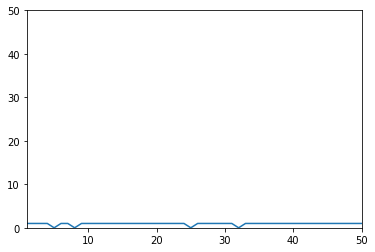

In [119]:
plt.plot(agente.get_reward())
plt.xlim([1, N])
plt.ylim([0, N])

Text(0,0.5,'Average Reward')

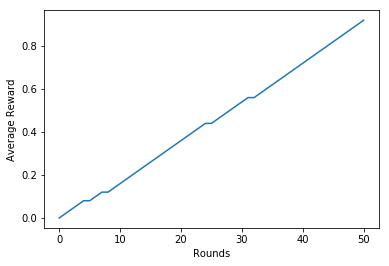

In [127]:
recompensa_acumulada=np.cumsum(agente.get_reward())
recompensa_promedio=recompensa_acumulada/N
plt.plot(recompensa_promedio)
plt.xlabel("Rounds")
plt.ylabel("Average Reward".format())

In [125]:
recompensa_acumulada

array([ 0,  1,  2,  3,  4,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 22, 23, 24, 25, 26, 27, 28, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [126]:
agente.get_reward()

[0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])